In [ ]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from files.functions import (
    base_dir,
    fullDataPath,
    dataSetup,
    trainingCols,
    _time_series_train_val_split,
    _scaler_factory,
    _tabular_future_forecast,
    _svm_param_grid,
    _svm_tune,
    _standardized_rmse,
    _save_model_artifact,
    _save_metrics,
)
from files.CONSTANTS import COIN, RESPONSE_VARIABLE, TRAINING_COLUMNS, TEST_DAYS, LIMIT
from implementations.svm_model import SVMModel

# SVM Training

Support Vector Machine (SVR) regression model for crypto price prediction.
This notebook uses the same tabular feature pipeline as GBM, performing a grid search
over kernel type (`rbf`, `linear`), regularization `C`, `epsilon`, and scaler method
using time-series cross-validation. Each step is shown explicitly.

Dataset shape: (730, 25)
Features (23): ['open', 'high', 'low', 'volume', 'value', 'SMA_7', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_STD', 'Volume_MA_7', 'OBV', 'avg_sentiment']
Target: close
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00


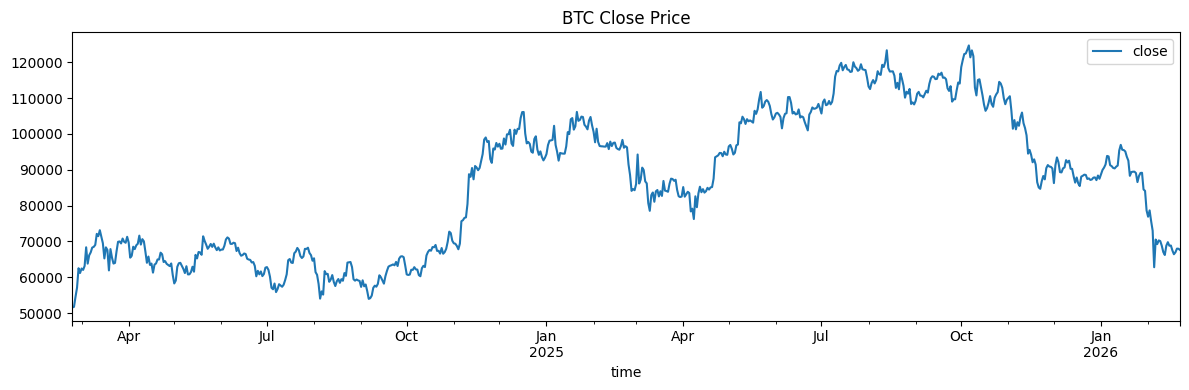


Train size: 584  |  Val size: 146


In [2]:
# ── Step 1: Load Data ────────────────────────────────────────────────────────
raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)
cols = trainingCols(TRAINING_COLUMNS)
X = daily_data[cols].copy()
y = daily_data[RESPONSE_VARIABLE].copy()
print(f"Dataset shape: {daily_data.shape}")
print(f"Features ({len(cols)}): {cols}")
print(f"Target: {RESPONSE_VARIABLE}")
print(f"Date range: {daily_data.index[0]} → {daily_data.index[-1]}")
daily_data[[RESPONSE_VARIABLE]].plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.tight_layout()
plt.show()

# ── Step 2: Train / Validation Split ─────────────────────────────────────────
X_train, X_val, y_train, y_val = _time_series_train_val_split(X, y)
print(f"\nTrain size: {len(X_train)}  |  Val size: {len(X_val)}")

In [3]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
param_grid = _svm_param_grid()
scaler_methods = ['standard', 'minmax', 'robust']

print(f"SVM param grid size: {len(param_grid)} configs")
print(f"Scaler methods: {scaler_methods}")
print(f"Total combinations: {len(param_grid) * len(scaler_methods)}")
print("\nSample configs:")
for cfg in param_grid[:3]:
    print(" ", cfg)

SVM param grid size: 12 configs
Scaler methods: ['standard', 'minmax', 'robust']
Total combinations: 36

Sample configs:
  {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
  {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
  {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [4]:
# ── Step 4: Tune Hyperparameters (includes scaler tuning) ────────────────────
print("Running SVM grid search with time-series CV...")
best_combo, tuning_results = _svm_tune(
    X_train, y_train, param_grid, scaler_methods=scaler_methods
)

print(f"\nBest combination found:")
for k, v in best_combo.items():
    print(f"  {k}: {v}")

# Display top-5 results
tuning_df = pd.DataFrame(tuning_results).sort_values('rmse').reset_index(drop=True)
print("\nTop-5 tuning results:")
print(tuning_df.head(5).to_string(index=False))

Running SVM grid search with time-series CV...

Best combination found:
  C: 10.0
  epsilon: 0.1
  gamma: scale
  kernel: linear
  scaler: standard
  rmse: 2538.8936969958045

Top-5 tuning results:
   C  epsilon gamma kernel   scaler         rmse
10.0     0.10 scale linear standard  2538.893697
10.0     0.01 scale linear standard  2539.164595
10.0     0.01 scale linear   robust  4829.158649
10.0     0.10 scale linear   robust  4829.319843
 1.0     0.10 scale linear standard 20325.114268


In [5]:
# ── Step 5: Train Best Model ──────────────────────────────────────────────────
best_scaler_method = best_combo['scaler']
model_params = {k: v for k, v in best_combo.items() if k not in ('scaler', 'rmse')}

# Fit scaler on training data
scaler = _scaler_factory(best_scaler_method)
X_train_s = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=cols
)
X_val_s = pd.DataFrame(
    scaler.transform(X_val), index=X_val.index, columns=cols
)

# Train SVM model (SVR expects numpy arrays)
model = SVMModel(**model_params)
model.fit(X_train_s.values, y_train.values)
print(f"SVM model trained with params: {model_params}")
print(f"Scaler: {best_scaler_method}")

SVM model trained with params: {'C': 10.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Scaler: standard


In [6]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
artifact_path = _save_model_artifact(
    {'model': model, 'scaler': scaler},
    COIN,
    f'{COIN}_svm_model.pkl'
)
print(f"Model artifact saved to: {artifact_path}")

Model artifact saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_svm_model.pkl


Validation RMSE:            1,597.68
Standardized RMSE (÷ std):  0.1094


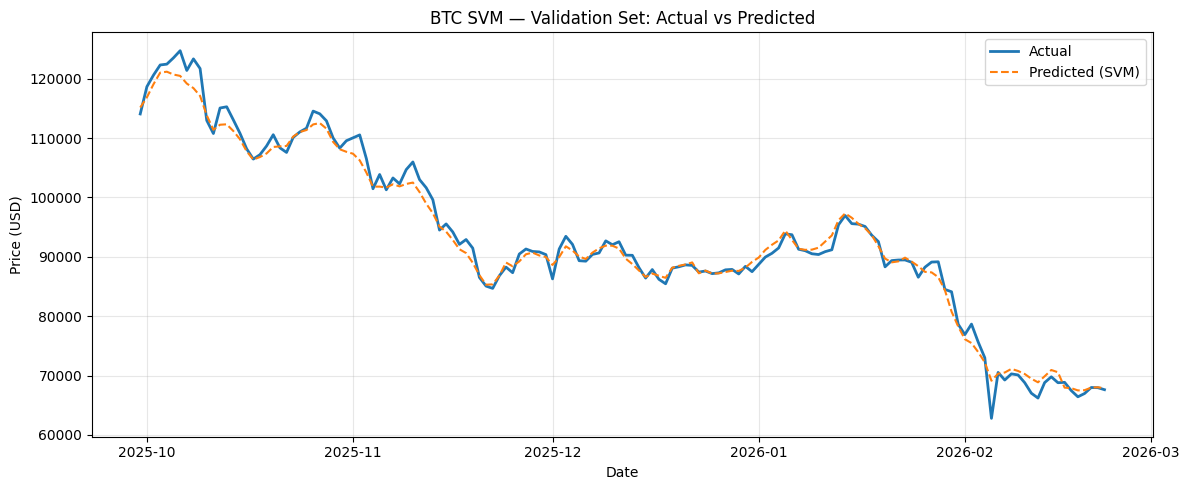

In [7]:
# ── Step 7: Predict on Validation Set ────────────────────────────────────────
val_preds = model.predict(X_val_s.values)
val_df = pd.DataFrame({'predicted_price': val_preds}, index=X_val_s.index)

# Compute RMSE
rmse, std_rmse = _standardized_rmse(y_val, val_preds)
print(f"Validation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (SVM)', linestyle='--')
ax.set_title(f"{COIN} SVM — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23     67873.817984
2026-02-24     67897.946509
2026-02-25     67903.815523
2026-02-26     67905.243100
2026-02-27     67905.590343
2026-02-28     67905.674807
2026-03-01     67905.695352


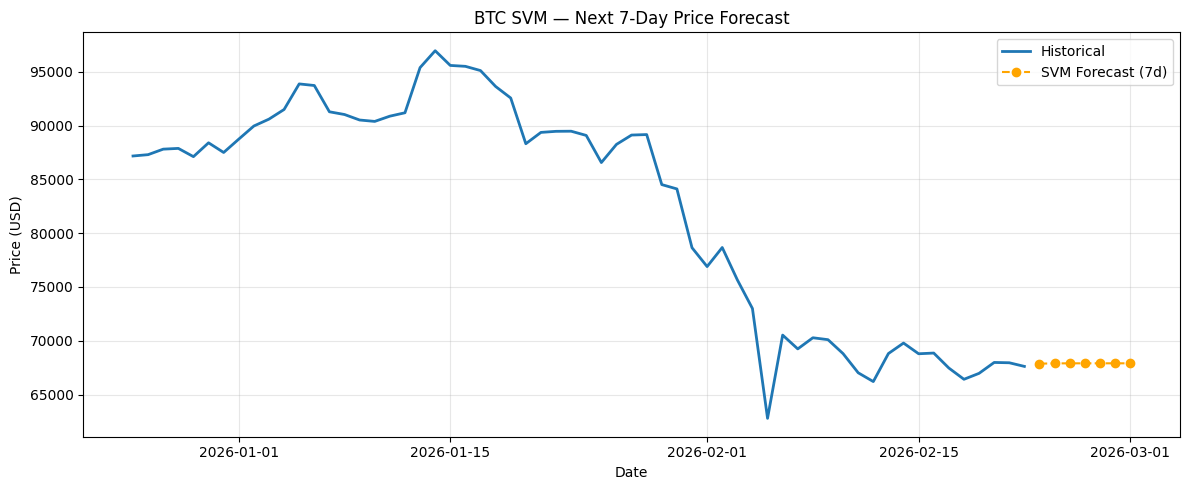

In [8]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
future_df = _tabular_future_forecast(
    model, scaler, X, daily_data, cols, RESPONSE_VARIABLE, n=TEST_DAYS
)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
hist = daily_data[RESPONSE_VARIABLE].iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'SVM Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} SVM — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ── Step 9: Save Metrics ──────────────────────────────────────────────────────
metrics_path = _save_metrics(std_rmse, COIN, 'svm')

print(f"Metrics (std RMSE) saved to: {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")